In [1]:
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Part A1: Running the Initial Model

## Basic Exploration and some visualisations

In [2]:
orioles = pd.read_excel('2001-2019 Orioles Historical Attendance File.xlsx')
orioles.head(5)

,Game #,Opponent -Abbrev,Opponent Team Name,Date,Month,Day,Year,Time*,Day.1,ATTENDANCE,...,Interleague,NYY,BOS,WSH,NIGHT,SAT.,Jun,Promo/Giveaway Item/Rain-Make-up Game Note,Bobblehead,Make-up Game
0,1,BOS,Red Sox,"Sun, Apr 04",Apr,4,2001,20:08:00,Sun,47482,...,0,0,1,0,1,0,0,Southwest Airlines - Magnet Schedule,0,0
1,2,BOS,Red Sox,"Tue, Apr 06",Apr,6,2001,15:05:00,Tue,35207,...,0,0,1,0,0,0,0,Southwest Airlines - Magnet Schedule,0,0
2,3,BOS,Red Sox,"Wed, Apr 07",Apr,7,2001,19:07:00,Wed,28315,...,0,0,1,0,1,0,0,NaN,0,0
3,4,BOS,Red Sox,"Thu, Apr 08",Apr,8,2001,19:08:00,Thu,31010,...,0,0,1,0,1,0,0,NaN,0,0
4,5,TB,Rays,"Tue, Apr 20",Apr,20,2001,19:07:00,Tue,21902,...,0,0,0,0,1,0,0,Bargain Night,0,0


In [3]:
#Basic Exploratory Analysis
orioles.info() #primarily to see the type of data (i.e. - object, float etc.)
orioles.describe() #to get a better feel of the data
orioles.isnull().sum() #check if there any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Game #                                      1518 non-null   object
 1   Opponent -Abbrev                            1518 non-null   object
 2   Opponent Team Name                          1518 non-null   object
 3   Date                                        1518 non-null   object
 4   Month                                       1518 non-null   object
 5   Day                                         1518 non-null   int64 
 6   Year                                        1518 non-null   int64 
 7   Time*                                       1518 non-null   object
 8   Day.1                                       1518 non-null   object
 9   ATTENDANCE                                  1518 non-null   int64 
 10  Weather                 

Game #                                          0
Opponent -Abbrev                                0
Opponent Team Name                              0
Date                                            0
Month                                           0
Day                                             0
Year                                            0
Time*                                           0
Day.1                                           0
ATTENDANCE                                      0
Weather                                         0
Opening Day                                     0
Holiday (Memorial Day/4th of July)              0
Interleague                                     0
NYY                                             0
BOS                                             0
WSH                                             0
NIGHT                                           0
SAT.                                            0
Jun                                             0


In [4]:
#lets see what we can convert into dummy variables (categorical features)
orioles.nunique()[orioles.nunique()<10] 

Month                                 8
Day.1                                 7
Opening Day                           2
Holiday (Memorial Day/4th of July)    2
Interleague                           2
NYY                                   2
BOS                                   2
WSH                                   2
NIGHT                                 2
SAT.                                  2
Jun                                   2
Bobblehead                            2
Make-up Game                          2
dtype: int64

In [5]:
#Lets convert time into an integer
orioles['timenum'] = ''
for i in range(len(orioles)):
    x = str(orioles.iloc[i]['Time*'])
    timenum = (int(x[0]+x[1]))*60 + (int(x[3]+x[4]))
    orioles['timenum'][i] = int(timenum)
orioles['timenum'] = pd.to_numeric(orioles['timenum']) #convert all into integer

In [6]:
#Lets split the weather into 2 categories: temperature and weather conditions
orioles['temp'] = ''
orioles['weather_cond'] = ''

#Lets first fill out all the temperatures
for i in range(len(orioles)):
    num = re.findall(r'\d{1,3}', orioles['Weather'][i]) #this will search for numbers between 1 and 3 digits
    orioles['temp'][i] = int(num[0])
orioles['temp'] = pd.to_numeric(orioles['temp']) #convert all into integer

    
#Now lets fill out all the 'weather conditions'
orioles['weather_cond'] = orioles['Weather'].str.lower() #first convert into lower case
for i in range(len(orioles)):
    text = re.sub(r'[0-9]', '',orioles['weather_cond'][i])
    text = re.sub(r'-', '',text)
    orioles['weather_cond'][i] = text

In [7]:
orioles['weather_cond'].nunique()
#Since there are 74 different values, it will not be feasible to turn these into dummy variables.
#Hence we will not account for this in the first model and will only focus on temperature in regards to weather.
#We'll come back to this when we try to improve the model

74

In [8]:
#Define X Features
X_features = ['Day.1','Opening Day','Holiday (Memorial Day/4th of July)', 'Interleague', 'NYY', 'BOS',
             'WSH', 'NIGHT','SAT.','Jun','Bobblehead', 'Make-up Game', 'timenum', 'temp']

#Creating dummy variables for the categorical feature
categorical = ['Day.1']
orioles_encoded = pd.get_dummies(orioles[X_features],columns = categorical,drop_first = True)
X_features = orioles_encoded.columns

#Define X and Y
X = sm.add_constant(orioles_encoded)
Y = orioles['ATTENDANCE']

#Split the data into training and test data
train_X, test_X, train_y, test_y = train_test_split( X ,Y,train_size = 0.8,random_state = 100)

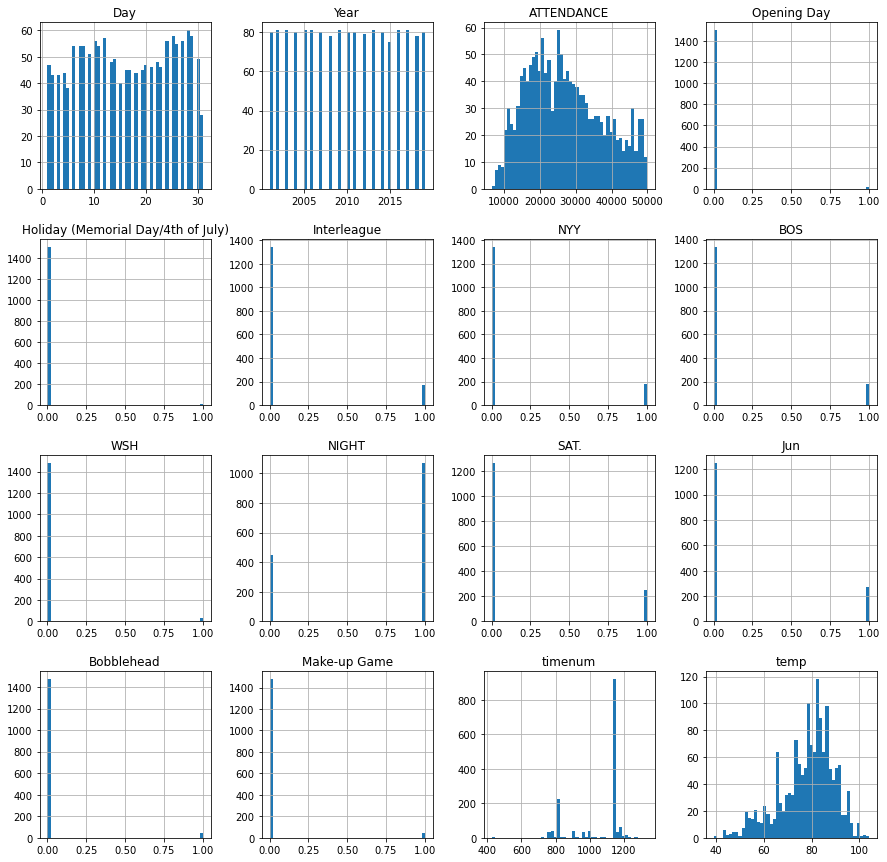

In [9]:
#Lets run a few basic visualisations
_ = orioles[orioles.columns].hist(bins=50, figsize=(15, 15)) # Basic histograms to get a feel of the data

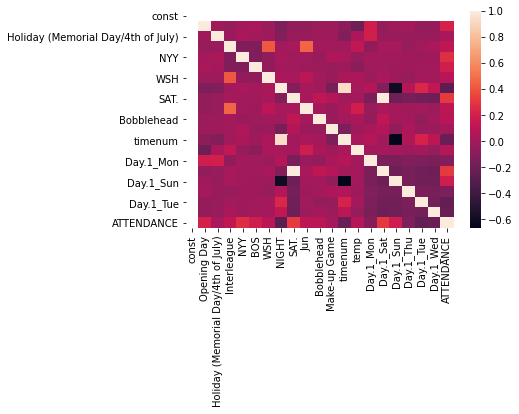

In [10]:
#Plotting a correlation heatmap
df = pd.concat([train_X, train_y], axis=1) #creating a dataframe combining train_X and train_y so that we can plot a heatmap
sns.heatmap(df.corr()) #plotting the heatmap 
plt.show()

## Running the initial model

In [11]:
orioles_model1 = sm.OLS(train_y, train_X).fit()
orioles_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ATTENDANCE   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     61.25
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          2.88e-155
Time:                        12:49:07   Log-Likelihood:                -12554.
No. Observations:                1214   AIC:                         2.515e+04
Df Residuals:                    1195   BIC:                         2.524e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               2.195e+04   4556.249      4.816      0.000     1.3e+04    3.09e+04
Opening Day                          2.28e+04   2113.610     10.789      0.000    1.87e+04     2.7e+04
Holiday (Memorial Day/4th of July)  3496.5859   3000.920      1.165      0.244   -2391.072    9384.244
Interleague                         4549.7190    875.247      5.198      0.000    2832.527    6266.911
NYY                                 1.044e+04    691.736     15.087      0.000    9079.091    1.18e+04
BOS                                 8550.9271    709.661     12.049      0.000    7158.607    9943.248
WSH                                 3626.8735   1548.740      2.342      0.019     588.322    6665.426
NIGHT                              -2473.2725   1489.998     -1.660      0.097   -5396.575     450.030
SAT.                                1245.9491    411.151      3.030      0.002     439.291    2052.607
Jun                                  573.7376    654.477      0.877      0.381    -710.315    1857.790
Bobblehead                          4700.9468   1245.462      3.774      0.000    2257.412    7144.482
Make-up Game                        -465.0505   1348.506     -0.345      0.730   -3110.754    2180.653
timenum                               -1.1389      4.835     -0.236      0.814     -10.626       8.348
temp                                 117.8267     20.357      5.788      0.000      77.887     157.766
Day.1_Mon                          -8806.9301    910.435     -9.673      0.000   -1.06e+04   -7020.701
Day.1_Sat                           1245.9491    411.151      3.030      0.002     439.291    2052.607
Day.1_Sun                          -1854.7729   1031.361     -1.798      0.072   -3878.252     168.706
Day.1_Thu                          -7717.1891    862.866     -8.944      0.000   -9410.090   -6024.289
Day.1_Tue                          -9272.3685    794.589    -11.669      0.000   -1.08e+04   -7713.423
Day.1_Wed                          -8940.8369    794.263    -11.257      0.000   -1.05e+04   -7382.531
==============================================================================
Omnibus:                       15.363   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.806
Skew:                           0.238   Prob(JB):                     0.000609
Kurtosis:                       2.742   Cond. No.                     1.35e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.68e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is s

# Part A2: Improving the Model

## Omitting values with higher p values & multicolinearity

In [12]:
#Calculating VIF to detect Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_vif_factors( X ):
    X_matrix = X.to_numpy()
    vif = [ variance_inflation_factor( X_matrix, i ) for i in range( X_matrix.shape[1] ) ]
    vif_factors = pd.DataFrame()
    vif_factors['column'] = X.columns
    vif_factors['vif'] = vif
    return vif_factors


vif_factors = get_vif_factors(X[X_features])
vif_factors

,column,vif
0,Opening Day,1.176613
1,Holiday (Memorial Day/4th of July),1.094517
2,Interleague,1.783381
3,NYY,1.195608
4,BOS,1.186165
5,WSH,1.258435
6,NIGHT,14.363069
7,SAT.,inf
8,Jun,1.584982
9,Bobblehead,1.054559


In [13]:
#Remove those columns that have unusually high values of multi-colinearity. These are also the columns with higher p-values
large_vif = vif_factors[vif_factors['vif'] > 4.0] #Lets see which have a vif score above 4
large_vif['column']
columns_to_be_removed = ["timenum", "temp", "Day.1_Sat"] #lets remove those columns that have a vif score above 4
X_features2 = list(set(X_features) - set(columns_to_be_removed))
get_vif_factors( X[X_features2] )

,column,vif
0,Holiday (Memorial Day/4th of July),1.055455
1,NYY,1.188655
2,Day.1_Thu,1.348036
3,WSH,1.257942
4,Day.1_Sun,1.107947
5,Bobblehead,1.053925
6,Day.1_Wed,1.475126
7,Opening Day,1.062264
8,Make-up Game,1.072970
9,SAT.,1.369895


## Omitting outliers

In [14]:
#Finding Z-Score for Outlier Analysis
from scipy.stats import zscore
orioles['z_score_attendance'] = zscore(orioles['ATTENDANCE'])
orioles[ (orioles.z_score_attendance > 3) | (orioles.z_score_attendance < -3)]
# Outliers are those that are either greater or less than 3 standard deviations.
# In this case, we have 6 different entries which would be considered "outliers".

,Game #,Opponent -Abbrev,Opponent Team Name,Date,Month,Day,Year,Time*,Day.1,ATTENDANCE,...,NIGHT,SAT.,Jun,Promo/Giveaway Item/Rain-Make-up Game Note,Bobblehead,Make-up Game,timenum,temp,weather_cond,z_score_attendance


In [15]:
train_X = train_X[X_features2]
test_X = test_X[X_features2]
orioles_model2 = sm.OLS(train_y, train_X).fit()
orioles_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             ATTENDANCE   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.865
Method:                 Least Squares   F-statistic:                              485.6
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                        0.00
Time:                        12:49:07   Log-Likelihood:                         -12978.
No. Observations:                1214   AIC:                                  2.599e+04
Df Residuals:                    1198   BIC:                                  2.607e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Holiday (Memorial Day/4th of July)   2.21e+04   4175.124      5.294      0.000    1.39e+04    3.03e+04
NYY                                 1.188e+04    976.108     12.170      0.000    9964.176    1.38e+04
Day.1_Thu                           7088.1425   1048.773      6.759      0.000    5030.506    9145.779
WSH                                 4690.2615   2192.629      2.139      0.033     388.442    8992.081
Day.1_Sun                           2.616e+04    800.981     32.662      0.000    2.46e+04    2.77e+04
Bobblehead                          4056.3761   1761.565      2.303      0.021     600.281    7512.472
Day.1_Wed                           5479.1573    945.894      5.793      0.000    3623.365    7334.950
Opening Day                         3.388e+04   2859.677     11.848      0.000    2.83e+04    3.95e+04
Make-up Game                        7859.9280   1877.155      4.187      0.000    4177.051    1.15e+04
SAT.                                2.103e+04    859.275     24.478      0.000    1.93e+04    2.27e+04
Interleague                         5856.8687   1237.833      4.732      0.000    3428.307    8285.430
NIGHT                               1.461e+04    636.506     22.957      0.000    1.34e+04    1.59e+04
Day.1_Mon                           4586.1860   1165.264      3.936      0.000    2300.000    6872.372
BOS                                 1.057e+04    997.107     10.601      0.000    8613.606    1.25e+04
Jun                                 2808.7536    912.608      3.078      0.002    1018.266    4599.241
Day.1_Tue                           3184.8233    998.771      3.189      0.001    1225.288    5144.358
==============================================================================
Omnibus:                       11.289   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.465
Skew:                           0.238   Prob(JB):                      0.00324
Kurtosis:                       2.988   Cond. No.                         12.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adding Variables

In [16]:
#Lets add a variable that tells us whether there is a promotion or not

#firsr lets convert null values into 0
orioles['Promo/Giveaway Item/Rain-Make-up Game Note'] = orioles['Promo/Giveaway Item/Rain-Make-up Game Note'].fillna(0)

orioles['promo_yn'] = ''
for i in range(len(orioles)):
    if orioles['Promo/Giveaway Item/Rain-Make-up Game Note'][i]==0:
       orioles['promo_yn'][i] = 0
    else:
        orioles['promo_yn'][i] = 1

orioles['promo_yn'] = pd.to_numeric(orioles['promo_yn']) #convert all into integer

In [17]:
#Lets see how weather_conditions affect attendance
bad = orioles.groupby('weather_cond')['ATTENDANCE'].mean().sort_values(ascending=True).head(10).to_frame().reset_index()
badlist = list(bad['weather_cond'])
badlist #these are the top 10 weathers which lead to poorest attendance

['lt rain',
 'raun delay',
 'chilly',
 'hazy',
 'pleasant',
 ' rain',
 'damp',
 'pycldy',
 'cool & rainy',
 'rain delay']

In [18]:
#Lets fill out a column that tells us whether the weather that day was amongst the top 10 worst weather list
orioles['bad_weather_yn'] = ''
for i in range(len(orioles)):
    if orioles['weather_cond'][i] in badlist:
        orioles['bad_weather_yn'][i] = 0
    else:
        orioles['bad_weather_yn'][i] = 1
    
orioles['bad_weather_yn'] = pd.to_numeric(orioles['bad_weather_yn']) #convert all into integer

In [19]:
#Adding our new variables into the existing train/test dataset

#Need to split the data again so that train/test dataset includes the new variables we have created

#Define X Features
X_features3 = ['Jun',
 'WSH',
 'Day.1',
 'Make-up Game',
 'Bobblehead',
 'NYY',
 'NIGHT',
 'BOS',
 'Opening Day',
 'Interleague',
 'Holiday (Memorial Day/4th of July)',
 'SAT.','bad_weather_yn', 'promo_yn']

#Creating dummy variables for the categorical feature
categorical = ['Day.1']
orioles_encoded = pd.get_dummies(orioles[X_features3],columns = categorical,drop_first = True)
X_features = orioles_encoded.columns

#Define X and Y
X = sm.add_constant(orioles_encoded)
Y = orioles['ATTENDANCE']

#Split the data into training and test data
train_X, test_X, train_y, test_y = train_test_split( X ,Y,train_size = 0.8,random_state = 100)

In [20]:
X_features3b = ['Jun',
 'WSH',
 'Day.1_Sun',
 'Make-up Game',
 'Day.1_Thu',
 'Bobblehead',
 'NYY',
 'NIGHT',
 'Day.1_Tue',
 'BOS',
 'Opening Day',
 'Interleague',
 'Holiday (Memorial Day/4th of July)',
 'SAT.',
 'Day.1_Mon',
 'Day.1_Wed','promo_yn', 'bad_weather_yn']

In [21]:
#Lets run the new model
train_X = train_X[X_features3b]
test_X = test_X[X_features3b]
orioles_model3 = sm.OLS(train_y, train_X).fit()
orioles_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             ATTENDANCE   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              799.5
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                        0.00
Time:                        12:49:08   Log-Likelihood:                         -12641.
No. Observations:                1214   AIC:                                  2.532e+04
Df Residuals:                    1196   BIC:                                  2.541e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Jun                                 1791.9140    693.031      2.586      0.010     432.222    3151.606
WSH                                 3260.1689   1665.131      1.958      0.050      -6.734    6527.072
Day.1_Sun                           5226.1587    973.676      5.367      0.000    3315.855    7136.463
Make-up Game                        -778.7637   1471.495     -0.529      0.597   -3665.762    2108.235
Day.1_Thu                          -2661.8182    909.186     -2.928      0.003   -4445.595    -878.041
Bobblehead                          2881.9921   1358.868      2.121      0.034     215.962    5548.023
NYY                                  1.09e+04    750.467     14.518      0.000    9423.187    1.24e+04
NIGHT                               1081.0988    669.522      1.615      0.107    -232.469    2394.667
Day.1_Tue                          -5632.7425    819.354     -6.875      0.000   -7240.274   -4025.211
BOS                                 8761.1321    763.594     11.474      0.000    7263.000    1.03e+04
Opening Day                         2.018e+04   2228.962      9.055      0.000    1.58e+04    2.46e+04
Interleague                         4171.9348    941.275      4.432      0.000    2325.201    6018.669
Holiday (Memorial Day/4th of July)  5004.4426   3223.419      1.553      0.121   -1319.742    1.13e+04
SAT.                                7889.3532    835.174      9.446      0.000    6250.784    9527.922
Day.1_Mon                          -2467.9553   1002.782     -2.461      0.014   -4435.363    -500.548
Day.1_Wed                          -3209.2045    858.047     -3.740      0.000   -4892.648   -1525.761
promo_yn                            4461.7790    547.163      8.154      0.000    3388.273    5535.285
bad_weather_yn                      1.986e+04    943.477     21.048      0.000     1.8e+04    2.17e+04
==============================================================================
Omnibus:                       19.490   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.232
Skew:                           0.314   Prob(JB):                     4.04e-05
Kurtosis:                       2.924   Cond. No.                         20.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* As we can see, our r squared score has improved significantly from the first model. It has gone from 0.480 to 0.866 and now it is at 0.923. Let's now use this model to test on our 'test' data

# Using only recent data (since 2014)

In [22]:
#Lets first create an index for the years after 2014
recent = orioles[orioles['Year']>=2014].reset_index()
recentlist = recent['index']
recentlist

0      1043
1      1044
2      1045
3      1046
4      1047
       ... 
470    1513
471    1514
472    1515
473    1516
474    1517
Name: index, Length: 475, dtype: int64

In [23]:
#Let's apply that index to our training data
train_X_recent = train_X.reset_index()
train_X_recent = train_X_recent.loc[train_X_recent['index'].isin(recentlist)]
train_y_recent = train_y.reset_index()
train_y_recent = train_y_recent.loc[train_y_recent['index'].isin(recentlist)]
train_y_recent = train_y_recent['ATTENDANCE']
test_X_recent = test_X.reset_index()
test_X_recent = test_X_recent.loc[test_X_recent['index'].isin(recentlist)]
test_y_recent = test_y.reset_index()
test_y_recent = test_y_recent.loc[test_y_recent['index'].isin(recentlist)]
test_y_recent = test_y_recent['ATTENDANCE']

In [24]:
#Lets now run the model with recent data only and see if it improves the model
train_X_recent = train_X_recent[X_features3b]
test_X_recent = test_X_recent[X_features3b]
orioles_model3_recent = sm.OLS(train_y_recent, train_X_recent).fit()
orioles_model3_recent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             ATTENDANCE   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              235.7
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                   2.87e-184
Time:                        12:49:08   Log-Likelihood:                         -3837.4
No. Observations:                 371   AIC:                                      7711.
Df Residuals:                     353   BIC:                                      7781.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Jun                                 1430.1292   1069.670      1.337      0.182    -673.598    3533.856
WSH                                 7021.9320   2440.741      2.877      0.004    2221.710    1.18e+04
Day.1_Sun                            571.4175   1869.282      0.306      0.760   -3104.912    4247.747
Make-up Game                       -2472.2105   2371.978     -1.042      0.298   -7137.196    2192.775
Day.1_Thu                          -4571.1532   1643.833     -2.781      0.006   -7804.091   -1338.215
Bobblehead                           662.7806   2375.054      0.279      0.780   -4008.254    5333.816
NYY                                 5351.3490   1284.074      4.167      0.000    2825.952    7876.746
NIGHT                              -1615.5231   1367.981     -1.181      0.238   -4305.941    1074.895
Day.1_Tue                          -7636.2928   1500.524     -5.089      0.000   -1.06e+04   -4685.201
BOS                                 2647.3122   1389.938      1.905      0.058     -86.289    5380.913
Opening Day                         2.014e+04   3794.998      5.307      0.000    1.27e+04    2.76e+04
Interleague                         2949.6259   1380.797      2.136      0.033     234.004    5665.248
Holiday (Memorial Day/4th of July)  8413.0496   4345.908      1.936      0.054    -134.078     1.7e+04
SAT.                                5568.5759   1495.786      3.723      0.000    2626.803    8510.349
Day.1_Mon                          -5530.1515   1767.225     -3.129      0.002   -9005.765   -2054.538
Day.1_Wed                          -6022.1847   1561.417     -3.857      0.000   -9093.034   -2951.336
promo_yn                            4934.5604   1017.641      4.849      0.000    2933.158    6935.963
bad_weather_yn                      2.295e+04   2033.126     11.290      0.000     1.9e+04     2.7e+04
==============================================================================
Omnibus:                        6.391   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.122
Skew:                           0.270   Prob(JB):                       0.0468
Kurtosis:                       2.676   Cond. No.                         17.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* If we use data from 2014 onwards, the r squared score remains unchanged. However, as we make the data more and more recent (i.e. - 2015, 2016 etc.), the r squared score becomes higher and higher. When we use only 2019 data, our r squared score is actually 0.973!
* However, this is likely due to overfitting. We don't want to restrict the data too much so we will restrict just from 2014 onwards rather than choosing to filter even more recent years. We choose 2014 onwards so that we have more data for the model to predict from, even at the cost of a few r squared points

In [25]:
#Defining the new variables given we will now use data only from 2014 onwards
train_X = train_X_recent
train_y = train_y_recent
test_X = test_X_recent
test_y = test_y_recent
orioles = recent

# Predicting our Test Values

In [26]:
#Let's try to predict the test values for Y and see how we do
linreg = LinearRegression()
linreg = linreg.fit(train_X,train_y)
y_predic = linreg.predict(test_X) #this stores our predicted values for test_y
y_predic_round = [round(num,0) for num in y_predic] #rounding the predictions as there were too many decimal places
results = pd.DataFrame({"Actual Y": test_y, "Predicted Y": y_predic_round}) #dataframe comparing actual with predicted
results

,Actual Y,Predicted Y
0,16299,20861.0
4,19729,20004.0
7,17849,20861.0
8,45785,42416.0
9,33156,23546.0
...,...,...
294,37359,29488.0
296,20048,29892.0
297,29950,18266.0
299,29102,27112.0


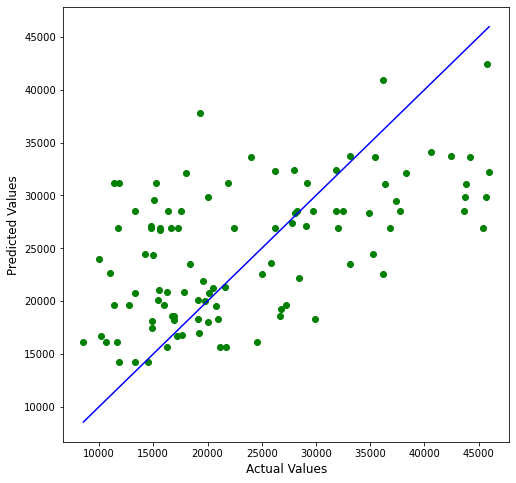

In [27]:
#Plotting actual with Predicted
plt.figure(figsize=(8,8))
plt.scatter(test_y, y_predic_round, c='green') #plotting actual values against predicting
p1 = max(max(y_predic_round), max(test_y)) #finding max value so we can plot "actual"straight line
p2 = min(min(y_predic_round), min(test_y)) #finding min value so we can plot "actual" straight line 
plt.plot([p1, p2], [p1, p2], 'b-') #plotting the "actual" straight line using the min and max values
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

plt.show()

# Part B - Prediction

* In the prediction file, we only have a few variables to work with so we can not use the exact same model that we used now
* We have date, day of the week, opposition, time, and promotion. From this, we can extract the following data that will be used as variables in our model:
    * Jun
    * WSH
    * Day.1_Sun
    * Day.1_Thu
    * Bobblehead
    * NYY
    * NIGHT
    * Day.1_Tue
    * BOS
    * Opening Day
    * Interleague (to be confirmed)
    * Holiday (Memorial Day/4th of July)
    * SAT.
    * Day.1_Mon
    * Day.1_Wed
    * promo_yn

## Create model for prediction

In [28]:
X_features4 = ['Jun',
 'WSH',
 'Day.1_Sun',
 'Day.1_Thu',
 'Bobblehead',
 'NYY',
 'NIGHT',
 'Day.1_Tue',
 'BOS',
 'Opening Day',
 'Interleague',
 'Holiday (Memorial Day/4th of July)',
 'SAT.',
 'Day.1_Mon',
 'Day.1_Wed',
 'promo_yn']

In [29]:
train_X[X_features4]

,Jun,WSH,Day.1_Sun,Day.1_Thu,Bobblehead,NYY,NIGHT,Day.1_Tue,BOS,Opening Day,Interleague,Holiday (Memorial Day/4th of July),SAT.,Day.1_Mon,Day.1_Wed,promo_yn
0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
10,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1197,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1202,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1204,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [30]:
#Lets run the new model
train_X = train_X[X_features4]
test_X = test_X[X_features4]
orioles_model4 = sm.OLS(train_y, train_X).fit()
orioles_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             ATTENDANCE   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              190.0
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                   5.06e-163
Time:                        12:49:09   Log-Likelihood:                         -3894.6
No. Observations:                 371   AIC:                                      7821.
Df Residuals:                     355   BIC:                                      7884.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Jun                                 3091.2763   1231.931      2.509      0.013     668.476    5514.076
WSH                                 5429.3595   2832.803      1.917      0.056    -141.826     1.1e+04
Day.1_Sun                           1.593e+04   1480.311     10.762      0.000     1.3e+04    1.88e+04
Day.1_Thu                           4912.8005   1607.685      3.056      0.002    1751.016    8074.585
Bobblehead                          -886.5403   2750.122     -0.322      0.747   -6295.119    4522.038
NYY                                 8249.5292   1447.123      5.701      0.000    5403.518    1.11e+04
NIGHT                               9372.8242   1072.016      8.743      0.000    7264.524    1.15e+04
Day.1_Tue                           -201.9481   1560.288     -0.129      0.897   -3270.517    2866.621
BOS                                 3996.9438   1610.991      2.481      0.014     828.658    7165.229
Opening Day                          2.84e+04   4296.163      6.610      0.000    1.99e+04    3.68e+04
Interleague                         4619.7131   1594.832      2.897      0.004    1483.207    7756.219
Holiday (Memorial Day/4th of July)  1.439e+04   4980.932      2.890      0.004    4598.562    2.42e+04
SAT.                                1.587e+04   1355.895     11.706      0.000    1.32e+04    1.85e+04
Day.1_Mon                           4230.2361   1768.389      2.392      0.017     752.400    7708.072
Day.1_Wed                           4198.8052   1467.296      2.862      0.004    1313.121    7084.490
promo_yn                            1.108e+04    960.902     11.535      0.000    9194.214     1.3e+04
==============================================================================
Omnibus:                        1.811   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.621
Skew:                           0.156   Prob(JB):                        0.445
Kurtosis:                       3.084   Cond. No.                         12.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Making the Predictions

In [32]:
pred = pd.read_excel('orioles_predictions.xlsx')
pred.head()

,#,DATE,DAY,OPP,TIME,PROMOTION/GIVEAWAY,FORECASTED ATTENDANCE
0,1,2022-03-31,Thu,TOR,15:05:00,Schedule Magnet,NaN
1,2,2022-04-02,Sat,TOR,19:05:00,Jacket/Pullover,NaN
2,3,2022-04-03,Sun,TOR,13:05:00,Lunch Bag,NaN
3,4,2022-04-11,Mon,MIL,19:05:00,NaN,NaN
4,5,2022-04-12,Tue,MIL,19:05:00,NaN,NaN


In [33]:
#Replace null values with zeros
pred['PROMOTION/GIVEAWAY'] = pred['PROMOTION/GIVEAWAY'].fillna(0)
pred['FORECASTED ATTENDANCE'] = pred['FORECASTED ATTENDANCE'].fillna(0)
pred.isnull().sum()

#                        0
DATE                     0
DAY                      0
OPP                      0
TIME                     0
PROMOTION/GIVEAWAY       0
FORECASTED ATTENDANCE    0
dtype: int64

In [34]:
#Create column that tells us if the game is in June
pred['Jun']=''

for i in range(len(pred)):
    if pd.DatetimeIndex(pred['DATE']).month[i] == 6:
        pred['Jun'][i] = 1
    else:
        pred['Jun'][i] = 0
        
pred['Jun'] = pd.to_numeric(pred['Jun']) #convert all into integer

In [35]:
#Create column that tells us if the game is against Washington Nationals
pred['WSH']=''

for i in range(len(pred)):
    if pred['OPP'][i] == 'WSH':
        pred['WSH'][i] = 1
    else:
        pred['WSH'][i] = 0
        
pred['WSH'] = pd.to_numeric(pred['WSH']) #convert all into integer

In [36]:
#Create column that tells us if there is a bobblehead promotion
pred['Bobblehead']=''

for i in range(len(pred)):
    if pred['PROMOTION/GIVEAWAY'][i] == 'Bobblehead':
        pred['Bobblehead'][i] = 1
    else:
        pred['Bobblehead'][i] = 0
        
pred['Bobblehead'] = pd.to_numeric(pred['Bobblehead']) #convert all into integer

In [37]:
#Create column that tells us if the game is against New York Yankees
pred['NYY']=''

for i in range(len(pred)):
    if pred['OPP'][i] == 'NYY':
        pred['NYY'][i] = 1
    else:
        pred['NYY'][i] = 0
        
pred['NYY'] = pd.to_numeric(pred['NYY']) #convert all into integer

In [38]:
#Create column that tells us if the game is at night
pred['NIGHT']=''

for i in range(len(pred)):
    x = str(pred.iloc[i]['TIME'])
    hour = int(x[0]+x[1])
    if hour >= 18: #Based on the histrocial data which states that games played after 6pm are considered night games
        pred['NIGHT'][i] = 1
    else:
        pred['NIGHT'][i] = 0
        
pred['NIGHT'] = pd.to_numeric(pred['NIGHT']) #convert all into integer

In [39]:
#Create column that tells us if the game is against Boston Red Sox
pred['BOS']=''

for i in range(len(pred)):
    if pred['OPP'][i] == 'BOS':
        pred['BOS'][i] = 1
    else:
        pred['BOS'][i] = 0
        
pred['BOS'] = pd.to_numeric(pred['BOS']) #convert all into integer

In [40]:
#Create column that tells us if the game is opening day or not
pred['Opening Day']=''

for i in range(len(pred)):
    if i == 0:
        pred['Opening Day'][i] = 1
    else:
        pred['Opening Day'][i] = 0
        
pred['Opening Day'] = pd.to_numeric(pred['Opening Day']) #convert all into integer

In [41]:
#Create column that tells us if the game is against an interleague team or not
pred['OPP'].unique()
interleagueteams = ['MIL', 'CHC', 'WSH', 'PIT']

pred['Interleague']=''

for i in range(len(pred)):
    if pred['OPP'][i] in (interleagueteams):
        pred['Interleague'][i] = 1
    else:
        pred['Interleague'][i] = 0
        
pred['Interleague'] = pd.to_numeric(pred['Interleague']) #convert all into integer

In [42]:
#Create column that tells us if the game will be on either memorial day or 4th of July
pred['Holiday (Memorial Day/4th of July)']=''

for i in range(len(pred)):
    if pd.DatetimeIndex(pred['DATE']).month[i] == 5  and pd.DatetimeIndex(pred['DATE']).day[i] == 30:  
        pred['Holiday (Memorial Day/4th of July)'][i] = 1
    else:
        if pd.DatetimeIndex(pred['DATE']).month[i] == 7 and pd.DatetimeIndex(pred['DATE']).day[i] == 4:
            pred['Holiday (Memorial Day/4th of July)'][i] = 1
        else:
            pred['Holiday (Memorial Day/4th of July)'][i] = 0

pred['Holiday (Memorial Day/4th of July)'] = pd.to_numeric(pred['Holiday (Memorial Day/4th of July)']) #convert all into integer

In [43]:
#Create column that tells us if the game is on a Monday
pred['Day.1_Mon']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Mon':
        pred['Day.1_Mon'][i] = 1
    else:
        pred['Day.1_Mon'][i] = 0
        
pred['Day.1_Mon'] = pd.to_numeric(pred['Day.1_Mon']) #convert all into integer

In [44]:
#Create column that tells us if the game is on a Tuesday
pred['Day.1_Tue']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Tue':
        pred['Day.1_Tue'][i] = 1
    else:
        pred['Day.1_Tue'][i] = 0
        
pred['Day.1_Tue'] = pd.to_numeric(pred['Day.1_Tue']) #convert all into integer

In [45]:
#Create column that tells us if the game is on a Wednesday
pred['Day.1_Wed']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Wed':
        pred['Day.1_Wed'][i] = 1
    else:
        pred['Day.1_Wed'][i] = 0
                
pred['Day.1_Wed'] = pd.to_numeric(pred['Day.1_Wed']) #convert all into integer

In [46]:
#Create column that tells us if the game is on a Thursday
pred['Day.1_Thu']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Thu':
        pred['Day.1_Thu'][i] = 1
    else:
        pred['Day.1_Thu'][i] = 0
                
pred['Day.1_Thu'] = pd.to_numeric(pred['Day.1_Thu']) #convert all into integer

In [47]:
#Create column that tells us if the game is on a Saturday
pred['SAT.']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Sat':
        pred['SAT.'][i] = 1
    else:
        pred['SAT.'][i] = 0
        
pred['SAT.'] = pd.to_numeric(pred['SAT.']) #convert all into integer

In [48]:
#Create column that tells us if the game is on a Sunday
pred['Day.1_Sun']=''

for i in range(len(pred)):
    if pred['DAY'][i] == 'Sun':
        pred['Day.1_Sun'][i] = 1
    else:
        pred['Day.1_Sun'][i] = 0
        
pred['Day.1_Sun'] = pd.to_numeric(pred['Day.1_Sun']) #convert all into integer

In [49]:
#Create column that tells us if there was a promotion or not

pred['promo_yn'] = ''
for i in range(len(pred)):
    if pred['PROMOTION/GIVEAWAY'][i]==0:
       pred['promo_yn'][i] = 0
    else:
        pred['promo_yn'][i] = 1
        
pred['promo_yn'] = pd.to_numeric(pred['promo_yn']) #convert all into integer

In [50]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   #                                   80 non-null     int64         
 1   DATE                                80 non-null     datetime64[ns]
 2   DAY                                 80 non-null     object        
 3   OPP                                 80 non-null     object        
 4   TIME                                80 non-null     object        
 5   PROMOTION/GIVEAWAY                  80 non-null     object        
 6   FORECASTED ATTENDANCE               80 non-null     float64       
 7   Jun                                 80 non-null     int64         
 8   WSH                                 80 non-null     int64         
 9   Bobblehead                          80 non-null     int64         
 10  NYY                         

In [51]:
#Let's now get our predicted vaues
pred_X = pred[X_features4]
linreg = LinearRegression()
linreg = linreg.fit(train_X,train_y)
y_predic = linreg.predict(pred_X) #this stores our predicted values for test_y
y_predic_round = [round(num,0) for num in y_predic] #rounding the predictions as there were too many decimal places
predictions = pd.DataFrame({"Predicted Y": y_predic_round}) #dataframe comparing actual with predicted
predictions

,Predicted Y
0,42978.0
1,30955.0
2,28358.0
3,18975.0
4,17264.0
...,...
75,15819.0
76,16620.0
77,26897.0
78,30955.0


In [52]:
#Lets just make sure there are no predictions greater than 46,500 (maximum capacity)
predictions[predictions['Predicted Y']>46500]

,Predicted Y


* There are no predictions greater than 46,500 (max capacity) which is good

In [53]:
#Finally, let's save our predictions to a separate csv file, which we will then copy paste into the excel sheet
predictions.to_csv("actual_predicted_values.csv")